## Overview

TODO: Add proper overview
We'll need a few libraries, including:

1) `anthropic` - to interact with Claude

2) `voyageai` - to generate high quality embeddings

3) `pandas`, `numpy`, `matplotlib`, and `scikit-learn` for data manipulation and visualization


You'll also need API keys from [Anthropic](https://www.anthropic.com/) and [Voyage AI](https://www.voyageai.com/)

In [1]:
## setup
# uncomment before first use:
# !pip install anthropic
# !pip install voyageai
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install -U scikit-learn

# Common Imports
Load the common imports here to be used later

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
import importlib



# Load datasets

Loading test and evaluation datasets

In [3]:
# Load the evaluation dataset
from Helpers.voyage_vector_db import VectorDB

with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Load the Anthropic documentation
with open('data/anthropic_docs.json', 'r') as f:
    anthropic_docs = json.load(f)

# Initialize the VectorDB
db = VectorDB("anthropic_docs")
db.load_data(anthropic_docs)

Loading vector database from disk.


## Evaluating Basic RAG

Preview of the first 3 items from evaluation/docs_evaluation_dataset.json:
[
  {
    "id": "efc09699",
    "question": "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases",
      "https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases"
    ],
    "correct_answer": "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."
  },
  {
    "id": "1305ea00",
    "question": "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/build-with-claude/embeddings#before-implementing-embeddings",
      "h

Evaluating End-to-End: 100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


Detailed LLM responses saved to: evaluation/xmls/evaluation_results_detailed.xml
Detailed results saved to: evaluation/csvs/evaluation_results_detailed.csv
Average Precision: 0.5000
Average Recall: 0.7500
Average MRR: 0.7500
Average F1: 0.6000
End-to-End Accuracy: 0.5000
Avg Metrics saved to: evaluation/json_results/evaluation_results_one.json


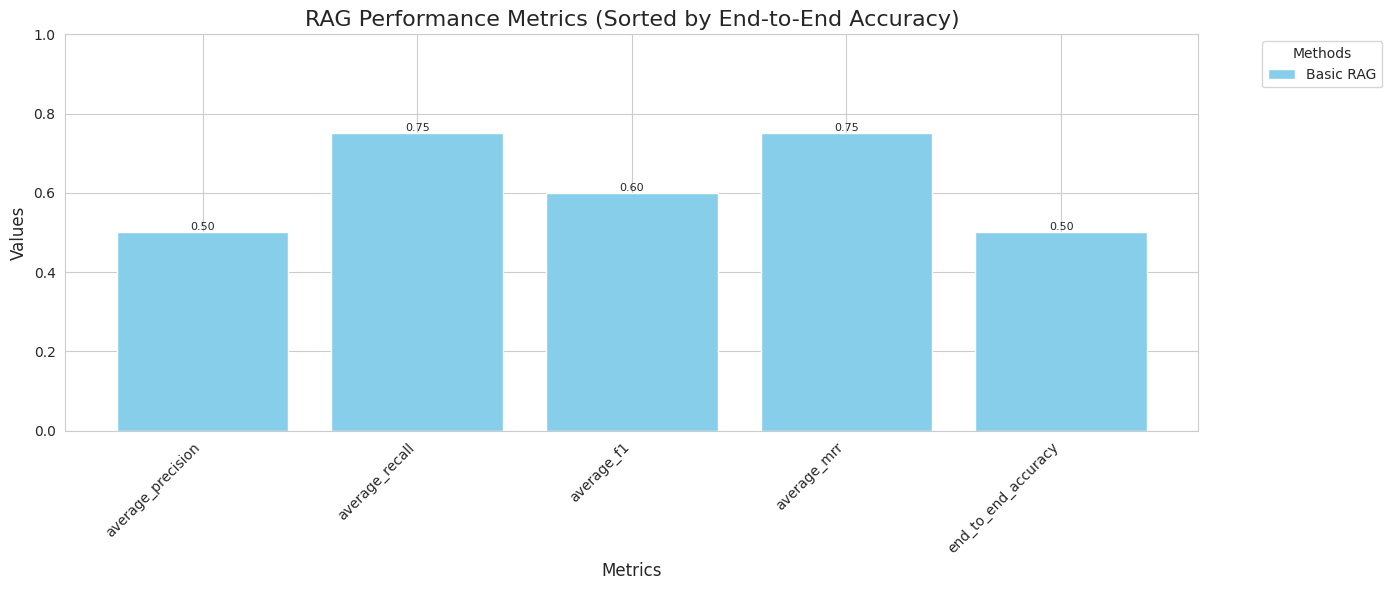

Evaluation complete


In [4]:
from basic_rag import evaluate_basic_rag

topK = 2
evaluate_basic_rag(eval_data, db, topK)

# Call OpenAI Custom GPT

Call the custom GPT using OpenAI APIs

In [14]:
from OpenAI.openAI_helpers import create_thread_and_run
from OpenAI.openAI_helpers import print_debug_logs


debug_logs = True
query = "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?"
chunk_links, response = create_thread_and_run(query, debug_logs)


# Print extracted values
print_debug_logs(f"Chunk Links:\n {chunk_links}", debug_logs)
print_debug_logs(f"Response:\n {response}", debug_logs)

threadId: thread_7mikNUzMqroei6kUKzcRDpdd
Value:
 <Sources>
  <Source>
    <chunk_heading>Creating Test Cases</chunk_heading>
    <chunk_link>https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases</chunk_link>
  </Source>
  <Source>
    <chunk_heading>Accessing the Evaluate Feature</chunk_heading>
    <chunk_link>https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#accessing-the-evaluate-feature</chunk_link>
  </Source>
  <Source>
    <chunk_heading>Understanding Results</chunk_heading>
    <chunk_link>https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#understanding-results</chunk_link>
  </Source>
  <Source>
    <chunk_heading>Tips for Effective Evaluation</chunk_heading>
    <chunk_link>https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#tips-for-effective-evaluation</chunk_link>
  </Source>
</Sources>

<Response>
To create multiple test cases for evaluation in the Anthropic Evaluation tool, follow these steps:

1. **Access

# Level 2: Document Summarization for Enhanced Retrieval

In this section, we'll implement an improved approach to our retrieval system by incorporating document summaries. Instead of embedding chunks directly from the documents, we'll create a concise summary for each chunk and use this summary along with the original content in our embedding process.

This approach aims to capture the essence of each document chunk more effectively, potentially leading to improved retrieval performance.

Key steps in this process:
1. We load the original document chunks.
2. For each chunk, we generate a 2-3 sentence summary using Claude.
3. We store both the original content and the summary for each chunk in a new json file: `data/anthropic_summary_indexed_docs.json`

This summary-enhanced approach is designed to provide more context during the embedding and retrieval phases, potentially improving the system's ability to understand and match the most relevant documents to user queries.

## Generating the Summaries and Storing Them

In [7]:
import json
from anthropic import Anthropic
from tqdm import tqdm

def generate_summaries(input_file, output_file):
 
    # Load the original documents
    with open(input_file, 'r') as f:
        docs = json.load(f)

    # Prepare the context about the overall knowledge base
    knowledge_base_context = "This is documentation for Anthropic's, a frontier AI lab building Claude, an LLM that excels at a variety of general purpose tasks. These docs contain model details and documentation on Anthropic's APIs."

    summarized_docs = []

    for doc in tqdm(docs, desc="Generating summaries"):
        prompt = f"""
        You are tasked with creating a short summary of the following content from Anthropic's documentation. 

        Context about the knowledge base:
        {knowledge_base_context}

        Content to summarize:
        Heading: {doc['chunk_heading']}
        {doc['text']}

        Please provide a brief summary of the above content in 2-3 sentences. The summary should capture the key points and be concise. We will be using it as a key part of our search pipeline when answering user queries about this content. 

        Avoid using any preamble whatsoever in your response. Statements such as 'here is the summary' or 'the summary is as follows' are prohibited. You should get straight into the summary itself and be concise. Every word matters.
        """

        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=150,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        summary = response.content[0].text.strip()

        summarized_doc = {
            "chunk_link": doc["chunk_link"],
            "chunk_heading": doc["chunk_heading"],
            "text": doc["text"],
            "summary": summary
        }
        summarized_docs.append(summarized_doc)

    # Save the summarized documents to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(summarized_docs, f, indent=2)

    print(f"Summaries generated and saved to {output_file}")

# generate_summaries('data/anthropic_docs.json', 'data/anthropic_summary_indexed_docs.json')

# Summary-Indexed Vector Database Creation

Here, we're creating a new vector database that incorporates our summary-enhanced document chunks. This approach combines the original text, the chunk heading, and the newly generated summary into a single text for embedding.

Key features of this process:
1. We create embeddings for the combined text (heading + summary + original content) using the Voyage AI API.
2. The embeddings and full metadata (including summaries) are stored in our vector database.
3. We implement caching mechanisms to improve efficiency in repeated queries.
4. The database is saved to disk for persistence and quick loading in future sessions.

This summary-indexed approach aims to create more informative embeddings, potentially leading to more accurate and contextually relevant document retrieval.

In [56]:
import os
import numpy as np
import pickle
import json
import voyageai

class SummaryIndexedVectorDB:
    def __init__(self, name, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/summary_indexed_vector_db.pkl"

    def load_data(self, data_file):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        with open(data_file, 'r') as f:
            data = json.load(f)

        texts = [f"{item['chunk_heading']}\n\n{item['text']}\n\n{item['summary']}" for item in data]  # Embed Chunk Heading + Text + Summary Together
        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            self.client.embed(
                texts[i : i + batch_size],
                model="voyage-2"
            ).embeddings
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data  # Store the entire item as metadata
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=3, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        # Ensure the directory exists
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

# Enhanced Retrieval Using Summary-Indexed Embeddings

In this section, we implement the retrieval process using our new summary-indexed vector database. This approach leverages the enhanced embeddings we created, which incorporate document summaries along with the original content.

Key aspects of this updated retrieval process:
1. We search the vector database using the query embedding, retrieving the top k most similar documents.
2. For each retrieved document, we include the chunk heading, summary, and full text in the context provided to the LLM.
3. This enriched context is then used to generate an answer to the user's query.

By including summaries in both the embedding and retrieval phases, we aim to provide the LLM with a more comprehensive and focused context. This could potentially lead to more accurate and relevant answers, as the LLM has access to both a concise overview (the summary) and the detailed information (the full text) for each relevant document chunk.

In [57]:
def retrieve_level_two(query, db):
    results = db.search(query, k=3)
    context = ""
    for result in results:
        chunk = result['metadata']
        context += f"\n <document> \n {chunk['chunk_heading']}\n\nText\n {chunk['text']} \n\nSummary: \n {chunk['summary']} \n </document> \n" #show model all 3 items
    return results, context

def answer_query_level_two(query, db):
    documents, context = retrieve_base(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2500,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    return response.content[0].text

## Evaluating This Method vs Basic RAG

In [ ]:
# Initialize the SummaryIndexedVectorDB
level_two_db = SummaryIndexedVectorDB("anthropic_docs_v2")
level_two_db.load_data('data/anthropic_summary_indexed_docs.json')

import pandas as pd

# Run the evaluations
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_level_two, eval_data, level_two_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_level_two, level_two_db, eval_data)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed_level_two.csv', index=False)
print("Detailed results saved to evaluation_results_detailed.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_level_two.json', 'w') as f:
    json.dump({
        "name": "Summary Indexing",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_level_two.json, evaluation_results_detailed_level_two.csv")

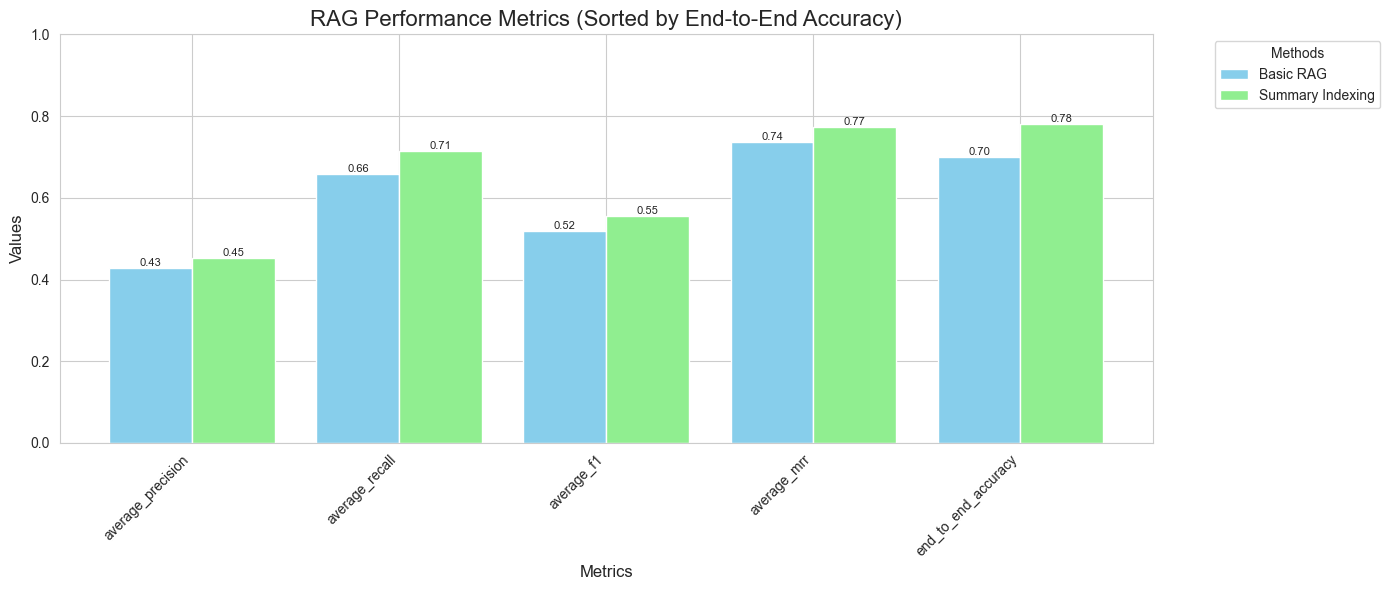

In [96]:
#visualizing our performance
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Indexing'])

## Level 3 - Re-Ranking with Claude
In this final enhancement to our retrieval system, we introduce a reranking step to further improve the relevance of the retrieved documents. This approach leverages Claude's power to better understand the context and nuances of both the query and the retrieved documents.

The `rerank_results` function uses Claude to reassess and reorder the initially retrieved documents:
1. It presents Claude with the query and summaries of all retrieved documents.
2. Claude is asked to select and rank the most relevant documents.
3. The function parses Claude's response to get the reranked document indices.
4. It includes fallback mechanisms in case of errors or insufficient results.
5. Finally, it assigns descending relevance scores to the reranked results.

The `retrieve_advanced` function implements the new retrieval pipeline:
1. We initially retrieve more documents than needed (default 20, configurable via `initial_k`) from the vector database.
2. We then use the `rerank_results` function to refine this larger set down to the most relevant documents (default 3, configurable via `k`).
3. Finally, it generates a new context string from these reranked documents.

This process casts a wider net initially and then uses AI to focus on the most pertinent information. By combining vector-based retrieval with LLM reranking, this approach aims to provide more accurate and contextually appropriate responses to user queries.

Our evaluations show significant improvements:
- Accuracy increased from 78% in our previous system to 85%.
- Precision was improved by using our re-ranker to reduce the number of documents shown to the LLM.
- MRR (Mean Reciprocal Rank) was likely improved by asking Claude to rank the relevance of each document in order.

These improvements demonstrate the effectiveness of incorporating AI-powered reranking in our retrieval process.

In [77]:
from typing import List, Dict

def rerank_results(query: str, results: List[Dict], k: int = 5) -> List[Dict]:
    # Prepare the summaries with their indices
    summaries = []
    print(len(results))

    for i, result in enumerate(results):
        summary = f"[{i}] Document Summary: {result['metadata']['summary']}"
        summaries.append(summary)
    joined_summaries = "\n\n".join(summaries)
    
    prompt = f"""
    Query: {query}
    You are about to be given a group of documents, each preceded by its index number in square brackets. Your task is to select the only {k} most relevant documents from the list to help us answer the query.
    
    <documents>
    {joined_summaries}
    </documents>

    Output only the indices of {k} most relevant documents in order of relevance, separated by commas, enclosed in XML tags here:
    <relevant_indices>put the numbers of your indices here, seeparted by commas</relevant_indices>
    """
    try:
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=50,
            messages=[{"role": "user", "content": prompt}, {"role": "assistant", "content": "<relevant_indices>"}],
            temperature=0,
            stop_sequences=["</relevant_indices>"]
        )
        
        # Extract the indices from the response
        response_text = response.content[0].text.strip()
        indices_str = response_text
        relevant_indices = []
        for idx in indices_str.split(','):
            try:
                relevant_indices.append(int(idx.strip()))
            except ValueError:
                continue  # Skip invalid indices
        print(indices_str)
        print(relevant_indices)
        # If we didn't get enough valid indices, fall back to the top k by original order
        if len(relevant_indices) == 0:
            relevant_indices = list(range(min(k, len(results))))
        
        # Ensure we don't have out-of-range indices
        relevant_indices = [idx for idx in relevant_indices if idx < len(results)]
        
        # Return the reranked results
        reranked_results = [results[idx] for idx in relevant_indices[:k]]
        # Assign descending relevance scores
        for i, result in enumerate(reranked_results):
            result['relevance_score'] = 100 - i  # Highest score is 100, decreasing by 1 for each rank
        
        return reranked_results
    
    except Exception as e:
        print(f"An error occurred during reranking: {str(e)}")
        # Fall back to returning the top k results without reranking
        return results[:k]

def retrieve_advanced(query: str, db: SummaryIndexedVectorDB, k: int = 3, initial_k: int = 20) -> Tuple[List[Dict], str]:
    # Step 1: Get initial results
    initial_results = db.search(query, k=initial_k)

    # Step 2: Re-rank results
    reranked_results = rerank_results(query, initial_results, k=k)
    
    # Step 3: Generate new context string from re-ranked results
    new_context = ""
    for result in reranked_results:
        chunk = result['metadata']
        new_context += f"\n <document> \n {chunk['chunk_heading']}\n\n{chunk['text']} \n </document> \n"
     
    return reranked_results, new_context

# The answer_query_advanced function remains unchanged
def answer_query_advanced(query: str, db: SummaryIndexedVectorDB):
    documents, context = retrieve_advanced(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2500,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.content[0].text

## Evaluation

In [ ]:
# Initialize the SummaryIndexedVectorDB
level_three_db = SummaryIndexedVectorDB("anthropic_docs_v3")
level_three_db.load_data('data/anthropic_summary_indexed_docs.json')

import pandas as pd

# Run the evaluations
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_advanced, eval_data, level_three_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_advanced, level_two_db, eval_data)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed_level_three.csv', index=False)
print("Detailed results saved to evaluation_results_detailed_level_three.csv")

# Plot the results
# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"Average Mean Reciprocal Rank: {avg_mrr:4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_data/evaluation_results_level_three.json', 'w') as f:
    json.dump({
        "name": "Summary Indexing + Re-Ranking",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_level_three.json, evaluation_results_detailed_level_three.csv, and evaluation_results_level_three.png")

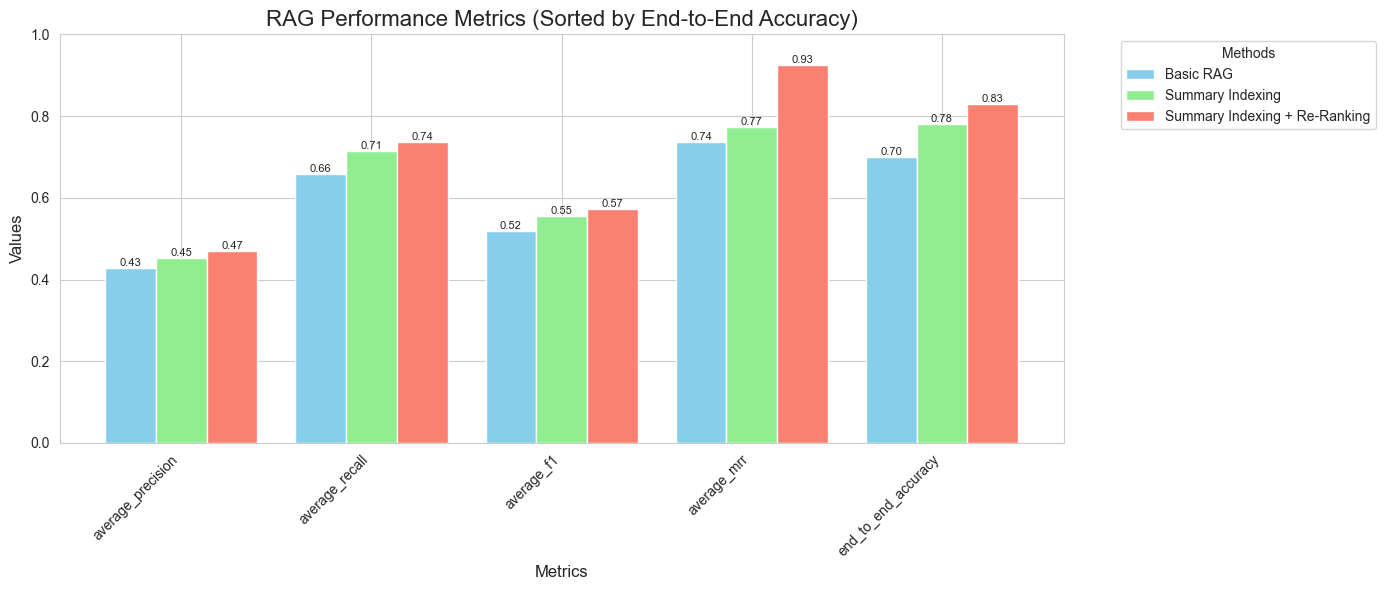

In [111]:
#visualizing our performance
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Indexing', 'Summary Indexing + Re-Ranking'], colors=['skyblue', 'lightgreen', 'salmon'])

## Evaluation - Going Deeper with Promptfoo

This guide has illustrated the importance of measuring prompt performance empirically when prompt engineering. You can read more about our empirical methodology to prompt engineering here. Using a Jupyter Notebook is a great way to start prompt engineering but as your datasets grow larger and your prompts more numerous it is important to leverage tooling that will scale with you.

In this section of the guide we will explore using Promptfoo an open source LLM evaluation toolkit. To get started head over to the ./evaluation directory and checkout the ./evaluation/README.md.

Promptfoo makes it very easy to build automated test suites that compare different models, hyperparameter choices, and prompts against one another. 

As an example, you can run the below cell to see the average performance of Haiku vs 3.5 Sonnet across all of our test cases. 

In [117]:
import json
import pandas as pd
import numpy as np

# Load the JSON file
with open('data/end_to_end_results.json', 'r') as f:
    data = json.load(f)

# Extract the results
results = data['results']['results']

# Create a DataFrame
df = pd.DataFrame(results)

# Extract provider, prompt, and score information
df['provider'] = df['provider'].apply(lambda x: x['label'] if isinstance(x, dict) else x)
df['prompt'] = df['prompt'].apply(lambda x: x['label'] if isinstance(x, dict) else x)

# Function to safely extract scores
def extract_score(x):
    if isinstance(x, dict) and 'score' in x:
        return x['score'] * 100  # Convert to percentage
    return np.nan

df['score'] = df['gradingResult'].apply(extract_score)

# Group by provider and prompt, then calculate mean scores
result = df.groupby(['provider', 'prompt'])['score'].mean().unstack()

# Fill NaN values with 0
result = result.fillna(0)

# Calculate the average score across all prompts for each provider
result['Average'] = result.mean(axis=1)

# Sort the result by the average score
result = result.sort_values(by='Average', ascending=False)

# Round the results to 2 decimal places
result = result.round(2)
# Calculate overall statistics
overall_average = result['Average'].mean()
overall_std = result['Average'].std()
best_provider = result['Average'].idxmax()
worst_provider = result['Average'].idxmin()

print(f"\nOverall Statistics:")
print(f"Best Performing Provider: {best_provider} ({result.loc[best_provider, 'Average']:.2f}%)")
print(f"Worst Performing Provider: {worst_provider} ({result.loc[worst_provider, 'Average']:.2f}%)")


Overall Statistics:
Best Performing Provider: 3.5 Sonnet: T-0.0 (85.00%)
Worst Performing Provider: Haiku: T-0.0 (78.00%)
